## Quantum reservoir computing

In this notebook we analyse the performance of the Ising model and study the number of gates needed to implement it in a quantum computer.

In [1]:
import numpy as np
from numpy.lib.scimath import sqrt as csqrt
from qiskit import QuantumCircuit
from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info import Statevector
from scipy.stats import unitary_group

from qiskit.opflow import StateFn
from qiskit.opflow import Z,X,Y
from qiskit.quantum_info import Pauli
from qiskit.opflow import *
from qiskit.circuit.library import Diagonal
from qiskit.extensions import  UnitaryGate

import random
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

import itertools

In [2]:
with open('../training_data/spectrums_LiH.npy', 'rb') as f:
            spectrums = np.load(f)
with open('../training_data/bond_lengths_LiH.npy', 'rb') as f:
            bond_lengths = np.load(f)
with open('../training_data/ground_states_LiH.npy', 'rb') as f:
            ground_states = np.load(f)

## Ising model

We simulate the time evolutio of the Ising model using first order Trotterization and exact simulation of the rotation gates. Later on, we will implement the time evolution using only the G3 family of gates.

First, we generate the obsevations from the quantum circuit.

In [4]:
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.circuit import QuantumRegister
from qiskit.opflow import StateFn
from qiskit.quantum_info import Pauli
from qiskit.opflow import *
from qiskit.circuit.library import Diagonal
from qiskit.extensions import  UnitaryGate
from qiskit.opflow import I, X, Y, Z
from qiskit.circuit import Parameter
from qiskit.opflow.evolutions import PauliTrotterEvolution,Suzuki

t = 10
nqbits = 8
qubit_idx = list(range(nqbits))
qubit_pairs = list(itertools.combinations(qubit_idx, 2))

pauli_op = 0
name_gate=''
for i in range(nqbits):
    name_gate+= 'I' 
for pair in qubit_pairs:
    name = name_gate[:pair[0]] + 'Z' + name_gate[(pair[0]+1):pair[1]] + 'Z' + name_gate[(pair[1]+1):]
    coef = np.random.normal(0.75, 0.1)
    pauli_op += coef*PauliOp(Pauli(name))

for qubit in qubit_idx:
    name = name_gate[:qubit] + 'X' + name_gate[(qubit+1):]
    coef = np.random.normal(1, 0.1)
    pauli_op += coef*PauliOp(Pauli(name))
    
evo_time = Parameter('θ')
evolution_op = (evo_time*pauli_op).exp_i()
trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evolution_op)
bound = trotterized_op.bind_parameters({evo_time: t})

qc_ham = bound.to_circuit()


obs_res = []
for i in tqdm(range(ground_states.shape[0])):

    initial_state = ground_states[i].round(6)
    initial_state/=np.sqrt(np.sum(initial_state**2))

    
    quantum_register = QuantumRegister(nqbits, 'q')

    qc = QuantumCircuit(quantum_register)

    qc.initialize(initial_state, list(range(nqbits)))

    qc += qc_ham
    
    observables = []
    op_name=''
    for j in range(nqbits):
        op_name+= 'I' 
    for j in range(nqbits):
        # X
        op_nameX = op_name[:j] + 'X' + op_name[(j+1):]
        obs = PauliOp(Pauli(op_nameX))
        observables.append(obs)
        # Y
        op_nameX = op_name[:j] + 'Y' + op_name[(j+1):]
        obs = PauliOp(Pauli(op_nameX))
        observables.append(obs)
        # Z
        op_nameX = op_name[:j] + 'Z' + op_name[(j+1):]
        obs = PauliOp(Pauli(op_nameX))
        observables.append(obs)

    results = []

    backend = BasicAer.get_backend('statevector_simulator')
    job = backend.run(transpile(qc, backend))
    qc_state = job.result().get_statevector(qc)

    for obs in observables:
        obs_mat = obs.to_spmatrix()
        expect = np.inner(np.conjugate(qc_state), obs_mat.dot(qc_state)).real
        results.append(expect)
        
    obs_res.append(results)
obs_res = np.array(obs_res)

100%|██████████| 300/300 [27:43<00:00,  5.54s/it]


## Generate target

The target of the model is

$$
y(t) = (\Delta E_1(r), \Delta E_2(r))
$$

We normalize $y(r)$ so that it lies between 0 and 1 for all the data.

In [5]:
num_states = ground_states.shape[0]
y = np.zeros((num_states, 2))
y[:,0] = spectrums[:,1] - spectrums[:,0]
y[:,1] = spectrums[:,2] - spectrums[:,0]

## Train and test data

In [6]:
X_train, X_test, y_train, y_test, bond_lengths_train, bond_lengths_test = train_test_split( 
    obs_res, y, bond_lengths, test_size=0.33, random_state=42)

## Scale y

In [7]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

## Train Ridge regression

In [10]:
lm = Ridge(alpha=1e-7)
lm.fit(X_train, y_train_scaled)

Ridge(alpha=1e-07)

## Test model

Mean Square Error  4.30118175534627e-07


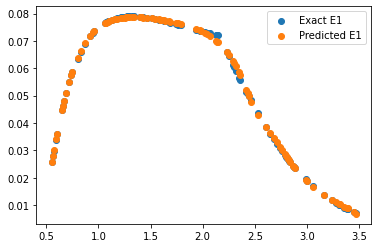

In [11]:
y_hat = lm.predict(X_test)
y_hat = scaler.inverse_transform(y_hat)

mse = np.mean(np.square(y_hat - y_test))
print('Mean Square Error ', mse)

plt.scatter(bond_lengths_test,y_test[:,0], label='Exact E1', marker='o')
plt.scatter(bond_lengths_test, y_hat[:,0], label='Predicted E1', marker='o')
plt.legend()
plt.show()

Now we just have to repeat this experiment 400 times varying the coefficients of the Ising model. The script `runQC_Ising`and  can be used to run the simulations. To run them, just type:

`python runQC_Ising.py name_molecule `

where 

+ name_molecule is either "LiH" or "H2O"

## Checking the size of the Ising model

Now we decompose the Ising model into circuit gates so that we can compare the number of gates with other circuits.

In [14]:
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.circuit import QuantumRegister
from qiskit.opflow import StateFn
from qiskit.opflow import Z,X,Y
from qiskit.quantum_info import Pauli
from qiskit.opflow import *
from qiskit.circuit.library import Diagonal
from qiskit.extensions import  UnitaryGate

nqbits = 8
qubit_idx = list(range(nqbits))
qubit_pairs = list(itertools.combinations(qubit_idx, 2))
t = 10

pauli_op = 0
name_gate=''
for i in range(nqbits):
    name_gate+= 'I' 
for pair in qubit_pairs:
    name = name_gate[:pair[0]] + 'Z' + name_gate[(pair[0]+1):pair[1]] + 'Z' + name_gate[(pair[1]+1):]
    coef = np.random.normal(0.75, 0.1)
    pauli_op += coef*PauliOp(Pauli(name))

for qubit in qubit_idx:
    name = name_gate[:qubit] + 'X' + name_gate[(qubit+1):]
    coef = np.random.normal(1, 0.1)
    pauli_op += coef*PauliOp(Pauli(name))
    
evo_time = Parameter('θ')
evolution_op = (evo_time*pauli_op).exp_i()
trotterized_op = PauliTrotterEvolution().convert(evolution_op)
bound = trotterized_op.bind_parameters({evo_time: t})

qc_ham = bound.to_circuit()



First, we transpile the circuit using the CNOT, RZ and H gates.

156


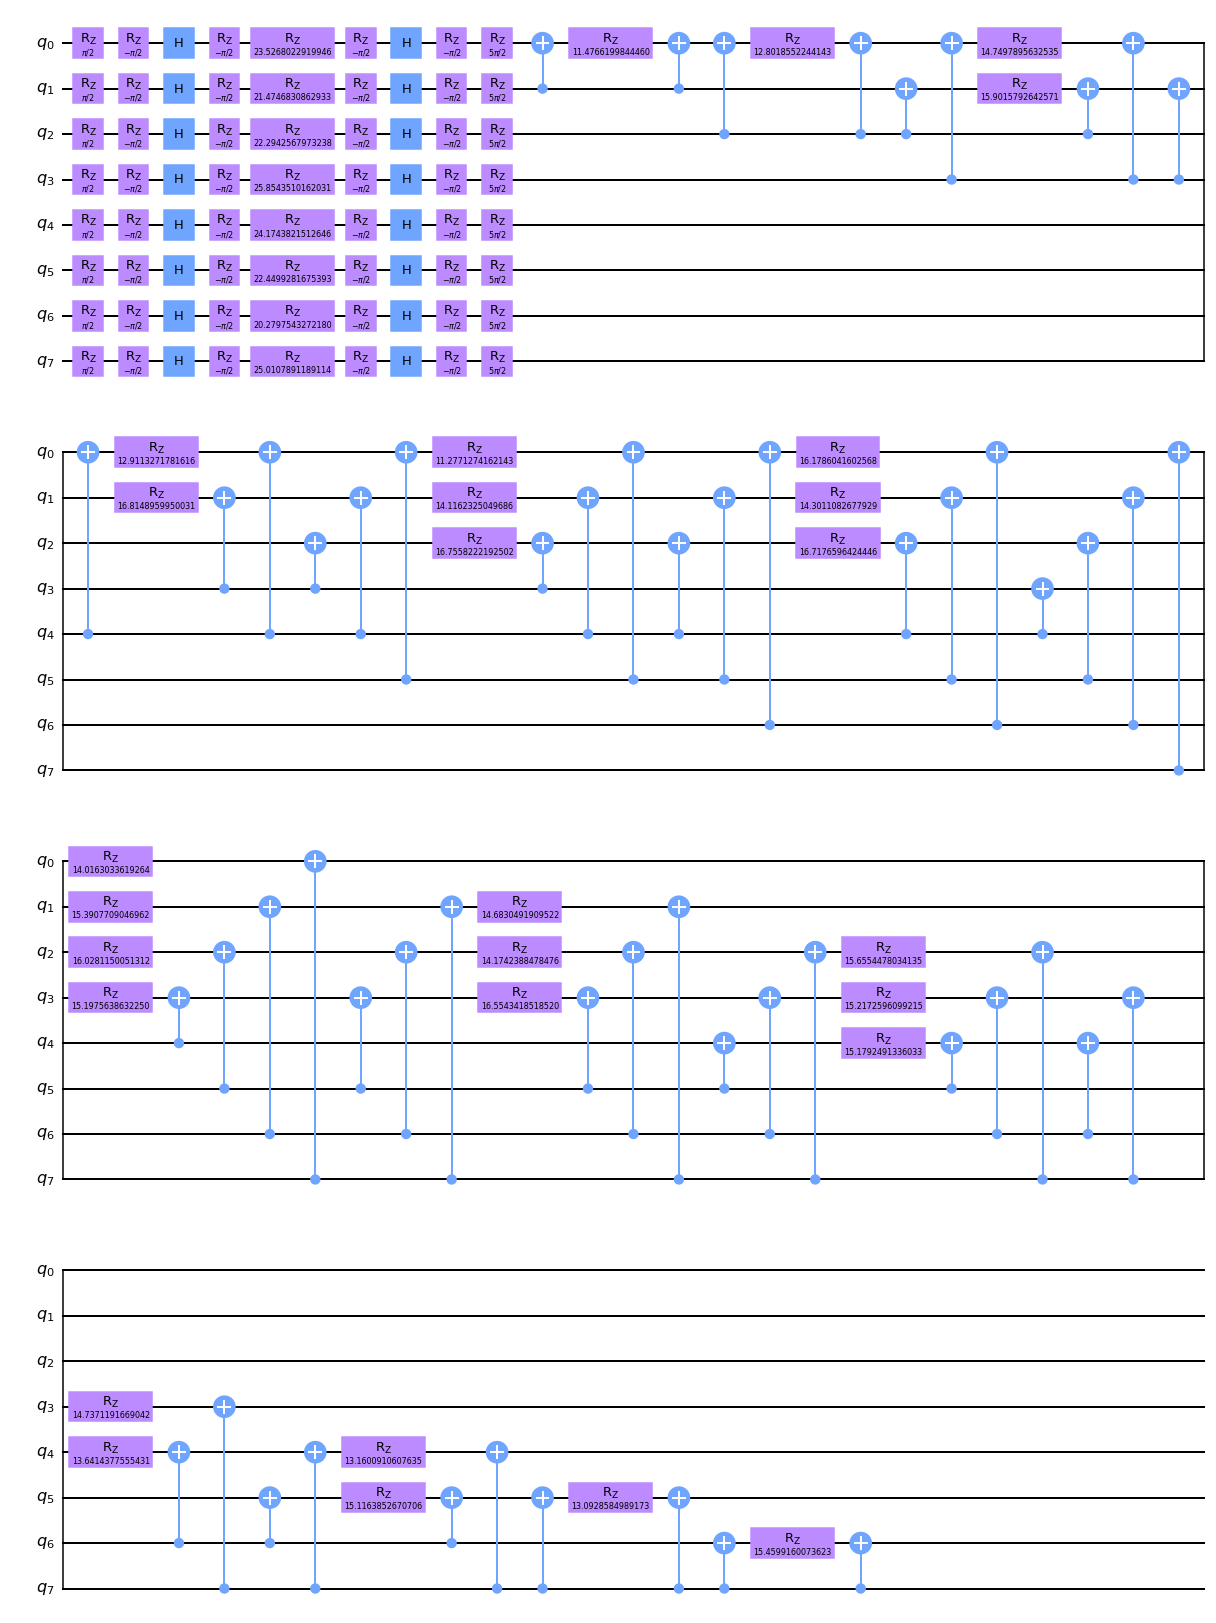

In [15]:
quantum_register = QuantumRegister(nqbits, 'q')
qc = QuantumCircuit(quantum_register)
qc += qc_ham
qc = transpile(qc, basis_gates=['cx', 'rz', 'h'])
print(qc.size())
qc.draw('mpl')


Notice that for the H2O there are 225 gates whilst for the LiH there are 156 gates. However, the set of gates for decomposing the circuit is {CNOT, H, RZ($\theta$)}, where $\theta$ varies. We now check how many different RZ($\theta$) are for the circuit.

In [16]:
angles = []
count_gates=0
for gate in qc.data:
    if gate[0].name=='rz':
        angle = float(gate[0].params[0])
        if angle<0:
            angle = 2*np.pi + angle
        angles.append(angle)
        count_gates+=1
angles = np.array(angles)
print(angles.shape)
print(count_gates)
angles

(84,)
84


array([ 1.57079633,  4.71238898,  4.71238898, 23.52680229,  4.71238898,
        4.71238898,  7.85398163,  1.57079633,  4.71238898,  4.71238898,
       21.47468309,  4.71238898,  4.71238898,  7.85398163, 11.47661998,
        1.57079633,  4.71238898,  4.71238898, 22.2942568 ,  4.71238898,
        4.71238898,  7.85398163, 12.80185522, 15.90157926,  1.57079633,
        4.71238898,  4.71238898, 25.85435102,  4.71238898,  4.71238898,
        7.85398163, 14.74978956, 16.814896  , 16.75582222,  1.57079633,
        4.71238898,  4.71238898, 24.17438215,  4.71238898,  4.71238898,
        7.85398163, 12.91132718, 14.1162325 , 16.71765964, 15.19756386,
        1.57079633,  4.71238898,  4.71238898, 22.44992817,  4.71238898,
        4.71238898,  7.85398163, 11.27712742, 14.30110827, 16.02811501,
       16.55434185, 15.17924913,  1.57079633,  4.71238898,  4.71238898,
       20.27975433,  4.71238898,  4.71238898,  7.85398163, 16.17860416,
       15.3907709 , 14.17423885, 15.21725961, 13.64143776, 15.11

There are 84 different Z-rotation gates. In order to compare with the other circuits, we decompose the circuit in the G3 family.

## Transpile circuit with {CNOT, H, t gates}

The G3 family gave the best results in terms of performance, with 200 gates. We use the algorithm described in 

N. J. Ross and P. Selinger, "Optimal ancilla-free Clifford+T approximation of z-rotations", arXiv:1403.2975.

to transpile the Ising circuit to the G3 set {CNOT, H, T}.

We use the Quantum Synthesis GridSynch package in 
https://hackage.haskell.org/package/newsynth-0.4.0.0/docs/Quantum-Synthesis-GridSynth.html to convert from rotation gate to a set of $H$ and $T$ gates.

In [17]:
import csv
with open('../HT_decomposition/angles_LiH.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(angles)

In [19]:
from itertools import zip_longest
def grouper(iterable, n, fillvalue=None):
         args = [iter(iterable)] * n
         return zip_longest(fillvalue=fillvalue, *args)

file = open('../HT_decomposition/LiH/output0.txt', 'r')
lines = file.readlines()
file.close()
lines = [element.strip() for element in lines]
lines = list(filter(None, lines))
phase_dict = {}

for phase, sequence in grouper(lines, 2):
    clean_seq = sequence.replace('S', 'TT')
    clean_seq = clean_seq.replace('X', 'HTTTTH')
    phase_dict[float(phase)] =  clean_seq
len(phase_dict)

39

We test with that the result applications of all the gates is equal to applying the RZ gate (up to precision $\epsilon = 10^{-10}$.)

In [233]:
from qiskit import Aer,execute

for idx in range(len(phase_dict)):
    list_gates = list(list(phase_dict.values())[idx]) 
    list_gates.reverse() # Reverse order because the order is matrix multiplication
    phase = list(phase_dict.keys())[idx]
    
    # Circuit with set of gates
    quantum_register = QuantumRegister(1, 'q')
    qc = QuantumCircuit(quantum_register)
    w_gates = 0
    for gate in list_gates:
        if gate=='H':
            qc.h(0)
        elif gate=='T':
            qc.t(0)
        elif gate=='W':
            w_gates+=1
        else:
            print('Unknown gate', gate)
    qc.global_phase = np.pi/4*w_gates 
    #backend = Aer.get_backend('statevector_simulator')
    #job = execute(qc, backend=backend, shots=1, memory=True)
    #state1 = job.result().get_statevector(qc)
    backend = BasicAer.get_backend('unitary_simulator')
    job = backend.run(transpile(qc, backend))
    unitary1 = job.result().get_unitary(qc)
    
    # Circuit with phase gate
    quantum_register = QuantumRegister(1, 'q')
    qc = QuantumCircuit(quantum_register)
    qc.rz(phase,0)

    #backend = Aer.get_backend('statevector_simulator')
    #job = execute(qc, backend=backend, shots=1, memory=True)
    #state2 = job_result.get_statevector(qc)
    job = backend.run(transpile(qc, backend))
    unitary2 = job.result().get_unitary(qc)
    print('Are the two unitaries the same? ', np.isclose(unitary1, unitary2, 1**(-10)).all())


Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two unitaries the same?  True
Are the two 

The results are indeed the same up to precision $10^{-10}$. To further check this result, we check that for each initial state, the original circuit (with Rz rotations) is the same as the transpiled circuit with H-T gates.

In [360]:
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import  UnitaryGate

w_gates=0

def add_rz_gate(idx, qc, qubit):
    global w_gates
    list_gates = list(list(phase_dict.values())[idx]) 
    list_gates.reverse() # Reverse order because the order is matrix multiplication
    phase = list(phase_dict.keys())[idx]
    
    # Circuit with set of gates
    for gate in list_gates:
        if gate=='H':
            qc.h(qubit)
        elif gate=='T':
            qc.t(qubit)
        elif gate=='W':
            w_gates+=1
        elif gate=='X':
            qc.x(qubit)
        else:
            print('Unknown gate', gate)
    
for j in range(ground_states.shape[0]):

    initial_state = ground_states[j].round(8)
    initial_state/=np.sqrt(np.sum(initial_state**2))
    w_gates=0

    # First create the circuit using RZ gates
    t=10
    quantum_register_aux = QuantumRegister(nqbits, 'q')
    qc_aux = QuantumCircuit(quantum_register_aux)
    qc_aux.initialize(initial_state, list(range(nqbits)))
    qc_aux +=qc_ham #hamiltonian.evolve(state_in = qc_aux, evo_time=t)
    qc_aux = transpile(qc_aux, basis_gates=['cx', 'rz', 'h'])
    # Calculate the unitary
    backend = BasicAer.get_backend('unitary_simulator')
    job = backend.run(transpile(qc_aux, backend))
    unitary1 = job.result().get_unitary(qc_aux)
    # Re define circuit without initialization
    quantum_register_aux = QuantumRegister(nqbits, 'q')
    qc_aux = QuantumCircuit(quantum_register_aux)
    qc_aux +=qc_ham # hamiltonian.evolve(state_in = qc_aux, evo_time=t)
    qc_aux = transpile(qc_aux, basis_gates=['cx', 'rz', 'h'])

    # Create circuit with G3 gates
    quantum_register_ising = QuantumRegister(nqbits, 'q')
    qc_ising = QuantumCircuit(quantum_register_ising)
    qc_ising.initialize(initial_state, list(range(nqbits)))

    i=0
    for data in qc_aux.data:
        gate_name = data[0].name
        if gate_name=='rz':
            theta = float(data[0].params[0])
        qubits = data[1]
        if len(qubits)==1:
            qubit = qubits[0].index
        elif len(qubits)==2:
            qubit1, qubit2 = qubits[0].index, qubits[1].index
        else:
            print('Other number of qubits', qubits)

        if gate_name=='rz':
            add_rz_gate(i, qc_ising, qubit) 
            i+=1
        elif gate_name=='cx':
            qc_ising.cx(qubit1, qubit2)
        elif gate_name=='h':
            qc_ising.h(qubit)
        else:
            print('Unknown gate', gate_name)
    qc_ising.global_phase = w_gates*np.pi/4 + qc_aux.global_phase

    backend = BasicAer.get_backend('unitary_simulator')
    job = backend.run(transpile(qc_ising, backend))
    unitary2 = job.result().get_unitary(qc_ising)

    print('Sample {}/{} Are the two unitaries the same? {}'.format(j,ground_states.shape[0],
                                                                   np.isclose(unitary1, unitary2, 1**(-10)).all()))

C:\Users\laiad\AppData\Local\Temp/ipykernel_10024/3630147719.py:61: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = qubits[0].index
C:\Users\laiad\AppData\Local\Temp/ipykernel_10024/3630147719.py:63: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit1, qubit2 = qubits[0].index, qubits[1].index


Sample 0/300 Are the two unitaries the same? True
Sample 1/300 Are the two unitaries the same? True
Sample 2/300 Are the two unitaries the same? True
Sample 3/300 Are the two unitaries the same? True
Sample 4/300 Are the two unitaries the same? True
Sample 5/300 Are the two unitaries the same? True
Sample 6/300 Are the two unitaries the same? True
Sample 7/300 Are the two unitaries the same? True
Sample 8/300 Are the two unitaries the same? True
Sample 9/300 Are the two unitaries the same? True
Sample 10/300 Are the two unitaries the same? True
Sample 11/300 Are the two unitaries the same? True
Sample 12/300 Are the two unitaries the same? True
Sample 13/300 Are the two unitaries the same? True
Sample 14/300 Are the two unitaries the same? True
Sample 15/300 Are the two unitaries the same? True
Sample 16/300 Are the two unitaries the same? True
Sample 17/300 Are the two unitaries the same? True
Sample 18/300 Are the two unitaries the same? True
Sample 19/300 Are the two unitaries the s

Sample 160/300 Are the two unitaries the same? True
Sample 161/300 Are the two unitaries the same? True
Sample 162/300 Are the two unitaries the same? True
Sample 163/300 Are the two unitaries the same? True
Sample 164/300 Are the two unitaries the same? True
Sample 165/300 Are the two unitaries the same? True
Sample 166/300 Are the two unitaries the same? True
Sample 167/300 Are the two unitaries the same? True
Sample 168/300 Are the two unitaries the same? True
Sample 169/300 Are the two unitaries the same? True
Sample 170/300 Are the two unitaries the same? True
Sample 171/300 Are the two unitaries the same? True
Sample 172/300 Are the two unitaries the same? True
Sample 173/300 Are the two unitaries the same? True
Sample 174/300 Are the two unitaries the same? True
Sample 175/300 Are the two unitaries the same? True
Sample 176/300 Are the two unitaries the same? True
Sample 177/300 Are the two unitaries the same? True
Sample 178/300 Are the two unitaries the same? True
Sample 179/3

## Create whole circuit

Now we create the whole circuit performing the time evolution over the Ising Hamiltonian, using only the G3 gates set.

In [234]:
w_gates=0

def add_rz_gate(theta, qc, qubit):
    global w_gates
    
    list_gates = list(phase_dict[theta]) 
    list_gates.reverse() # Reverse order because the order is matrix multiplication

    # Circuit with set of gates
    for gate in list_gates:
        if gate=='H':
            qc.h(qubit)
        elif gate=='T':
            qc.t(qubit)
        elif gate=='W':
            w_gates+=1
        else:
            print('Unknown gate', gate)
    

# First create the circuit using RZ gates
quantum_register_aux = QuantumRegister(nqbits, 'q')
qc_aux = QuantumCircuit(quantum_register_aux)
qc_aux +=qc_ham #hamiltonian.evolve(state_in = qc_aux, evo_time=t)
qc_aux = transpile(qc_aux, basis_gates=['cx', 'rz', 'h'])

backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(qc_aux, backend))
unitary1 = job.result().get_unitary(qc_aux)
    
# Create circuit with G3 gates
quantum_register_ising = QuantumRegister(nqbits, 'q')
qc_ising = QuantumCircuit(quantum_register_ising)

i=0
for data in qc_aux.data:
    gate_name = data[0].name
    qubits = data[1]
    if gate_name=='rz':
        theta = float(data[0].params[0])
        if theta<0:
            theta = 2*np.pi + theta
        qubit = qubits[0].index
        add_rz_gate(theta, qc_ising, qubit) 
        i+=1
    elif gate_name=='cx':
        qubit1, qubit2 = qubits[0].index, qubits[1].index
        qc_ising.cx(qubit1, qubit2)
    elif gate_name=='h':
        qubit = qubits[0].index
        qc_ising.h(qubit)
    else:
        print('Unknown gate', gate_name)
qc_ising.global_phase = qc_aux.global_phase + w_gates*np.pi/4

backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(qc_ising, backend))
unitary2 = job.result().get_unitary(qc_ising)

C:\Users\laiad\AppData\Local\Temp/ipykernel_21232/1152302816.py:43: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = qubits[0].index
C:\Users\laiad\AppData\Local\Temp/ipykernel_21232/1152302816.py:50: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = qubits[0].index
C:\Users\laiad\AppData\Local\Temp/ipykernel_21232/1152302816.py:47: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit1, qubit2 = qubits[0].index, qubits[1].index


In [235]:
print('Ising Hamiltonian circuit size:', qc_ising.size())

Ising Hamiltonian circuit size: 17088


In [236]:
print('Gate set: ', np.unique([gate[0].name for gate in qc_ising.data]))

Gate set:  ['cx' 'h' 't']


In [237]:
print('Are both circuits the same? ', np.isclose(unitary1,unitary2, 10**(-5)).all())

Are both circuits the same?  True


Now we add the initial states and perform the measurements.

In [353]:
obs_res = []
for i in tqdm(range(ground_states.shape[0])):

    initial_state = ground_states[i].round(8)
    initial_state/=np.sqrt(np.sum(initial_state**2))

    quantum_register = QuantumRegister(nqbits, 'q')

    qc_initial = QuantumCircuit(quantum_register)

    qc_initial.initialize(initial_state, list(range(nqbits)))

    qc = qc_initial + qc_ising
    
    observables = []
    op_name=''
    for j in range(nqbits):
        op_name+= 'I' 
    for j in range(nqbits):
        # X
        op_nameX = op_name[:j] + 'X' + op_name[(j+1):]
        obs = PauliOp(Pauli(op_nameX))
        observables.append(obs)
        # Y
        op_nameX = op_name[:j] + 'Y' + op_name[(j+1):]
        obs = PauliOp(Pauli(op_nameX))
        observables.append(obs)
        # Z
        op_nameX = op_name[:j] + 'Z' + op_name[(j+1):]
        obs = PauliOp(Pauli(op_nameX))
        observables.append(obs)

    results = []

    backend = BasicAer.get_backend('statevector_simulator')
    job = backend.run(transpile(qc, backend))
    qc_state = job.result().get_statevector(qc)

    for obs in observables:
        obs_mat = obs.to_spmatrix()
        expect = np.inner(np.conjugate(qc_state), obs_mat.dot(qc_state)).real
        results.append(expect)
        
    obs_res.append(results)

100%|██████████| 300/300 [29:43<00:00,  5.94s/it]


## Generate sizes of circuit

Finally, we compute the number of gates needed to transpile the Ising operator for 400 simulations of the Ising model.

In [614]:
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.circuit import QuantumRegister
from qiskit.opflow import StateFn
from qiskit.opflow import Z,X,Y
from qiskit.quantum_info import Pauli
from qiskit.opflow import *
from qiskit.circuit.library import Diagonal
from qiskit.extensions import  UnitaryGate
from itertools import zip_longest
import subprocess
import csv
def grouper(iterable, n, fillvalue=None):
         args = [iter(iterable)] * n
         return zip_longest(fillvalue=fillvalue, *args)
w_gates=0

def add_rz_gate(theta, qc, qubit):
    global w_gates
    
    list_gates = list(phase_dict[theta]) 
    list_gates.reverse() # Reverse order because the order is matrix multiplication

    # Circuit with set of gates
    for gate in list_gates:
        if gate=='H':
            qc.h(qubit)
        elif gate=='T':
            qc.t(qubit)
        elif gate=='W':
            w_gates+=1
        else:
            print('Unknown gate', gate)
    

nqbits = 8
qubit_idx = list(range(nqbits))
qubit_pairs = list(itertools.combinations(qubit_idx, 2))
t = 10

sizes = []
coeffs1 = []
coeffs2 = []
for j in tqdm(range(400)):
    # 1. DEFINE HAMILTONIAN
    pauli_op = 0
    name_gate=''
    for i in range(nqbits):
        name_gate+= 'I' 
    for pair in qubit_pairs:
        name = name_gate[:pair[0]] + 'Z' + name_gate[(pair[0]+1):pair[1]] + 'Z' + name_gate[(pair[1]+1):]
        coef1 = np.random.normal(0.75, 0.1)
        coeffs1.append(coef1)
        pauli_op += coef1*PauliOp(Pauli(name))

    for qubit in qubit_idx:
        name = name_gate[:qubit] + 'X' + name_gate[(qubit+1):]
        coef2 = np.random.normal(1, 0.1)
        coeffs2.append(coef2)
        pauli_op += coef2*PauliOp(Pauli(name))

    evo_time = Parameter('θ')
    evolution_op = (evo_time*pauli_op).exp_i()
    trotterized_op = PauliTrotterEvolution().convert(evolution_op)
    bound = trotterized_op.bind_parameters({evo_time: t})

    qc_ham = bound.to_circuit()
    
    #2. CREATE QUANTUM CIRCUIT WITH QISKIT
    quantum_register_aux = QuantumRegister(nqbits, 'q')
    qc_aux = QuantumCircuit(quantum_register_aux)
    qc_aux += qc_ham
    qc_aux = transpile(qc_aux, basis_gates=['cx', 'rz', 'h'])
    
    #3. GET THE ANGLES OF THE ROTATIONS
    angles = []
    count_gates=0
    for gate in qc_aux.data:
        if gate[0].name=='rz':
            angle = float(gate[0].params[0])
            if angle<0:
                angle = 2*np.pi + angle
            angles.append(angle)
            count_gates+=1
    angles = np.array(angles)
    
    # 4. STORE THE ANGLES IN A FILE
    with open('angles_LiH.csv', 'w') as f:
        writer = csv.writer(f, delimiter='\n')
        writer.writerow(angles)
    
    # 5. RUN HT DECOMPOSITION
    # CHANGE YOUR PATH HERE
    program = r'C:\Users\laiad\Desktop\phd\quantum computing\quantum-majorization\GitHub\HT_decomposition\decompose_LiH.bat'
    filename = 'output' + str(j) + '.txt'
    subprocess.call([program, filename])
    
    # 6. READ OUTPUT
    # CHANGE YOUR PATH HERE
    file = open(r'C:/Users/laiad/Desktop/phd/quantum computing/quantum-majorization/GitHub/HT_decomposition/' + filename, 'r')
    lines = file.readlines()
    file.close()
    lines = [element.strip() for element in lines]
    lines = list(filter(None, lines))
    phase_dict = {}

    for phase, sequence in grouper(lines, 2):
        clean_seq = sequence.replace('S', 'TT')
        clean_seq = clean_seq.replace('X', 'HTTTTH')
        phase_dict[float(phase)] =  clean_seq
    
    # 7. CREATE QISKIT CIRCUIT AND ADD GATES
    quantum_register_ising = QuantumRegister(nqbits, 'q')
    qc_ising = QuantumCircuit(quantum_register_ising)
    k=0
    for data in qc_aux.data:
        gate_name = data[0].name
        qubits = data[1]
        if gate_name=='rz':
            theta = float(data[0].params[0])
            if theta<0:
                theta = 2*np.pi + theta
            qubit = qubits[0].index
            add_rz_gate(theta, qc_ising, qubit) 
            k+=1
        elif gate_name=='cx':
            qubit1, qubit2 = qubits[0].index, qubits[1].index
            qc_ising.cx(qubit1, qubit2)
        elif gate_name=='h':
            qubit = qubits[0].index
            qc_ising.h(qubit)
        else:
            print('Unknown gate', gate_name)
    qc_ising.global_phase = qc_aux.global_phase + w_gates*np.pi/4
    
    # 8. GET SIZE OF THE CIRCUIT
    sizes.append(qc_ising.size())
sizes = np.array(sizes)

  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\laiad\AppData\Local\Temp/ipykernel_21232/3719758195.py:120: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = qubits[0].index
C:\Users\laiad\AppData\Local\Temp/ipykernel_21232/3719758195.py:127: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = qubits[0].index
C:\Users\laiad\AppData\Local\Temp/ipykernel_21232/3719758195.py:124: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit1, qubit2 = qubits[0].index, qubits[1].index
100%|██████████| 400/400 [16:30<00:00,  2.48s/it]


In [20]:
with open('../results/LiH/Ising_sizes/sizes.npy', 'rb') as f:
            sizes1 = np.load(f)
        
with open('../results/H2O/Ising_sizes/sizes.npy', 'rb') as f:
            sizes2 = np.load(f)

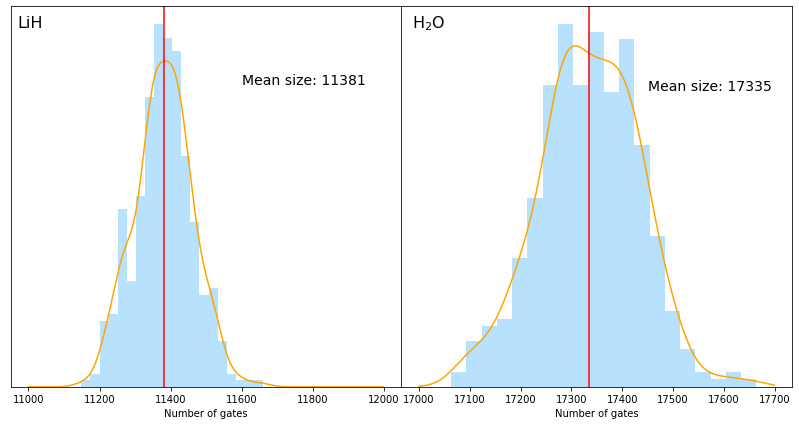

In [21]:
from scipy import stats

fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (14,7))

x = np.arange(11000,12000,1)
ax1.hist(sizes1, density=True, alpha=0.6, bins=20, color='lightskyblue')
kde = stats.gaussian_kde(sizes1)
ax1.plot(x, kde(x), color='orange')
ax1.axvline(x=np.mean(sizes1), color='red')
ax1.text(11600, 0.0045, 'Mean size: '+ str(int(np.mean(sizes1))), fontsize=14)
ax1.set_xlabel('Number of gates')
ax1.set_title('LiH', y=0.93, x=0.05, fontsize=16)

x = np.arange(17000,17700,1)
ax2.hist(sizes2, density=True, alpha=0.6, bins=20, color='lightskyblue')
kde = stats.gaussian_kde(sizes2)
ax2.plot(x, kde(x), color='orange')
ax2.axvline(x=np.mean(sizes2), color='red')
ax2.text(17450, 0.00327, 'Mean size: '+ str(int(np.mean(sizes2))), fontsize=14)
ax2.set_xlabel('Number of gates')
ax2.set_title('$\mathrm{H_2O}$', y=0.93, x=0.07, fontsize=16)

plt.subplots_adjust(wspace=0, hspace=0)
plt.setp(ax1,  yticks=[])
plt.setp(ax2,  yticks=[])
plt.savefig('../figures/Ising.png', format='png')
plt.show()